In [1]:
%matplotlib inline

In [2]:
#!pip install cufflinks plotly

In [3]:
#!pip install ipynb

In [4]:
#standard imports for calculations, dataframes work, plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import pandas_datareader as web
from pandas.plotting import lag_plot
import datetime as dt
import matplotlib.ticker as ticker
import seaborn as sns

#interactive plotting
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import plotly.graph_objects as go

#for RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

#holidays handling
from pandas.tseries.offsets import BDay

#fixing an issue with pandas and matplotlib regarding datetime index
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
#from scipy import interpolate
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.tsatools import detrend

#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

#Autocorrelation
from pandas.plotting import autocorrelation_plot as acp
from statsmodels.tsa.stattools import acf, q_stat
from statsmodels.graphics.tsaplots import plot_acf

#Time series, data split, cross validator
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split

#normalizing data
from sklearn.preprocessing import MinMaxScaler

#ML 
from sklearn.linear_model import LinearRegression, ElasticNet
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 
from statsmodels.tsa.arima_model import ARIMA

import pickle

np.random.seed(2209)

# Machine Learning for Predicting Stock Risk Premium

### Author: Yana Stamenova

## Abstract

In this project, we chose to challenge ourselves by trying to apply machine learning algorithms to predict stock returns. Working with time series offers many opportunities to make mistakes. We have made mistakes too. We applied Linear regression, Elastic net and ARIMA models to make predictions. The results from the models did not satisfy our expectations for a well working model. The good news is that it is not all bad. We noticed there are points we can work on in the future and actually increase the performance of the ARIMA model. We can also apply other interesting models to try to challenge our time series.

## Introduction
In this project, our main objective is to apply machine learning models for daily asset return predictions. For this purpose, we chose to work with data for the Microsoft stock. We will use features such as the S&P 500 and oil futures prices to try to make better predictions where possible. We will perform feature engineering on our data, including calculating returns instead of working with prices. The reason behind this is that returns data has a better chance to be stationary, a very important assumption for our regression models. We will assess the results from our models, make conclusions and give ideas for further improvements to this project.  

### Abbreviations
 - **ECU** - European Currency Unit
 - **ML** - Machine learning
 - **TS** - Time series
 - **ACF** - Autocorrelation function
 - **PACF** - Partial autocorrelation function
 - **ARIMA** - Auto Regressive Integrated Moving Average
 - **FRED** - Federal Reserve Bank of St. Louis
 - **RMSE** - Root mean squared error
 - **MSFT** - Microsoft

### Functions

In [5]:
def set_date_index(data):
    data.Date = pd.to_datetime(data.Date)    
    #set index
    data = data.set_index("Date")
    return data

In [6]:
def rename_columns(data):
    data = data.rename(columns = {
        "Open": "open",
        "High": "high", 
        "Low": "low",     
        "Close": "close",
        "Volume": "volume",
        "Dividends": "dividends",
        "Stock Splits": "stock_splits"})
    return data

In [7]:
def plot_stock_data(data, stock_name, color, scale):
    """ Plot data allowing to choose the y-scale
    """
    plt.rcParams.update({'font.size': 14})
    plt.plot(data, color = color, label = stock_name, linewidth = 1)
    plt.yscale(scale)
    plt.xlabel('Year')
    # upgrade axis tick labels
    dates_rng = pd.date_range(data.index[0], data.index[-1], freq='2Y')
    plt.xticks(dates_rng, [dtz.strftime('%Y-%m') for dtz in dates_rng], rotation=45)
    plt.ylabel("Price ($)")
    plt.legend(loc = "best")

In [8]:
def show_important_events(data):
    """TODO: Explain better
    Show through vertical span significant events on the plot
    In this case - three recessions and three market crashes
    """
    start = data.index.min()
    end = data.index.max()

    #recession data
    f1 = 'USREC' # recession data from FRED
    reccessions_data = (web.DataReader([f1], 'fred', start, end)
            .join(data, how='outer')
            .dropna())
    
        # recessions are marked as 1 in the data
    recs = reccessions_data.query('USREC==1')

        # Select the two recessions over the time period
    recs_90s = recs.loc['1990']
    recs_00s = recs.loc['2001']
    recs_08s = recs.loc['2008']

        # now we can grab the indices for the start
        # and end of each recession

    recs_90s_bgn = recs_90s.index[0]
    recs_90s_end = recs_90s.index[-1]

    recs_00s_bgn = recs_00s.index[0]
    recs_00s_end = recs_00s.index[-1]

    recs_07s_bgn = recs_08s.index[0]
    recs_07s_end = recs_08s.index[-1]
    
        #reccessions
    plt.axvspan(recs_90s_bgn, recs_90s_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
    plt.axvspan(recs_00s_bgn, recs_00s_end,  color=sns.xkcd_rgb['grey'], alpha=0.5)
    plt.axvspan(recs_07s_bgn, recs_07s_end,  color=sns.xkcd_rgb['grey'], alpha=0.5)

        #single day crashes
    plt.axvspan(pd.to_datetime('1987-10-19'), pd.to_datetime('1987-10-19'), color=sns.xkcd_rgb['red'], alpha=0.5)
    plt.axvspan(pd.to_datetime('1989-10-13'), pd.to_datetime('1989-10-13'),  color=sns.xkcd_rgb['red'], alpha=0.5)
    plt.axvspan(pd.to_datetime('2010-5-6'), pd.to_datetime('2010-5-6'),  color=sns.xkcd_rgb['red'], alpha=0.5)


In [9]:
def show_max_min_return(data, return_type):
    """Fancy :) 
    Show max/min returns and their dates for the period covered
    """
    # MAX Return
    data_max_ = data[return_type].max()
    data_max_idx_ = data[return_type].idxmax(axis=0, skipna=True)

    # MIN Return
    data_min_ = data[return_type].min()
    data_min_idx_ = data[return_type].idxmin(axis=0, skipna=True)

    bbox_props = dict(boxstyle="round4, pad=0.6", fc="darkgoldenrod", ec="b", lw=.5)

    plt.annotate('Global Max = {:.2%}\nDate = {}'
                     .format(data_max_, data_max_idx_.strftime('%a, %Y-%m-%d')),
                fontsize=10,
                fontweight='bold',
                xy=(data_max_idx_, data_max_),  
                xycoords='data',
                xytext=(-150, -30),      
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"), bbox=bbox_props)    

    plt.annotate('Global Min = {:.2%}\nDate = {}'
                     .format(data_min_, data_min_idx_.strftime('%a, %Y-%m-%d')),
                fontsize=10,
                fontweight='demi',
                xy=(data_min_idx_, data_min_),  
                xycoords='data',
                xytext=(-150, 30),      
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->"), bbox=bbox_props) 

    # now to use tight layout
    plt.tight_layout()

In [10]:
def plot_data(df):
    """Plot data, using Plotly. The plot is interactive. By clicking on the values of the legend 
    you can choose which values you want to see. 
    You can also zoom in/out, using the slider or the menu above the plot.
    The menu will show up when you point the mouse over it. 
    The menu also gives opportunity to compare data on hover.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['open'],
                    name="Open",
                    line_color='blueviolet',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['high'],
                    name="High",
                    line_color='green',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['low'],
                    name="Low",
                    line_color='red',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['close'],
                    name="Close",
                    line_color='darkcyan',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['volume'],
                    name="Volume",
                    line_color='darkolivegreen',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['dividends'],
                    name="Dividends",
                    line_color='darkgoldenrod',
                    opacity=0.8))
    
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['stock_splits'],
                    name="Stock splits",
                    line_color='brown',
                    opacity=0.8))
    
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['rolmean_20'],
                    name="Moving average 20d",
                    line_color='darkkhaki',
                    opacity=0.8))
    
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['rolmean_50'],
                    name="Moving average 50d",
                    line_color='brown',
                    opacity=0.8))
    
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['rolmean_200'],
                    name="Moving average 200d",
                    line_color='darkslategray',
                    opacity=0.8))

    fig.update_layout(title_text='Explore data',
                  xaxis_rangeslider_visible=True)   
    fig.show()

In [11]:
def calculate_log_return(data_close, data_open):
    """ The logarithmic return or continuously compounded return.
    R_log = ln(V_f/V_i),
    where:
     V_f = final value in the end of the period
     V_i = initial value
    """
    data_return = np.log(data_close/data_open) * 100
    return data_return

In [12]:
def calculate_return(data_close, data_open):
    """ The return over a single period of any length of time.
    R = (V_f - V_i)/V_i
    where:
     V_f = final value in the end of the period
     V_i = initial value
    """
    data_return = (data_close - data_open) / data_open * 100
    return data_return

In [13]:
def test_stationarity(timeseries):
    """ The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root,
    with the alternative that there is no unit root. If the pvalue is above a critical size,
    then we cannot reject that there is a unit root.
    This function also shows Rolling (Moving) mean and Rolling standard deviation. It gives better visual 
    understanding of the data and its stationarity/ non-stationarity.
    
    """
    plt.figure(figsize = (16,8), linewidth=3, frameon = False)
    #Determing rolling statistics
    rolmean_20 = timeseries.rolling(window = 20).mean()
    #rolmean_50 = timeseries.rolling(window = 50).mean()
    rolmean_200 = timeseries.rolling(window = 200).mean() #choosing this window because ...
    rolstd = timeseries.rolling(window = 200).std()
    
    #Plot rolling statistics:
    
    orig = plt.plot(timeseries, color = 'darkcyan',label = 'Original')
    mean_20 = plt.plot(rolmean_20, color = 'orange', label = 'Rolling Mean 20d')
    #mean_50 = plt.plot(rolmean_50, color = 'orange', label = 'Rolling Mean')
    mean_200 = plt.plot(rolmean_200, color = 'brown', label = 'Rolling Mean 200d')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std 200d')
    plt.legend(loc = 'best')
    plt.title('Augmented Dickey-Fuller test')
    plt.grid(b = True, which = "both", linestyle = '--', linewidth = 1, alpha = 0.3)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
def add_moving_average(data):
    """Rolling(moving) averages are used to analyze the time-series
    data by calculating averages of different subsets of the complete dataset.
    The moving average smoothens the data.
    The rolling functions used here are pandas.Dataframe functions
    
    """
    data["rolmean_20"] = data.close.rolling(window = 20).mean()
    data["rolmean_50"] = data.close.rolling(window = 50).mean()
    data["rolmean_200"] = data.close.rolling(window = 200).mean()
    

In [15]:
#used this to check if data contains is free from holidays
#isBusinessDay = BDay().onOffset
#business_days_check = pd.to_datetime(df.index).map(isBusinessDay)
#business_days_check.shape
#business_days_check.unique()

### Deffinitions

* **Time-series** - A collection of observations collected over constant time intervals. 
* **Risk premium** - The return in excess of the risk-free rate of return investment is expected to yield
* **Risk-free rate of return** - The theoretical rate of return on investment with zero risk. In practice, such an "animal" does not exist. The three-month U.S. treasury bill is often used as the risk-free rate for U.S.-based investors.
* **White noise**[<sup>2</sup>](#fn2) - A sequence of uncorrelated random variables with constant variance and constant mean. Plots of white noise series have unpredictable behavior.
* **Stationary time series**[<sup>3</sup>](#fn3) - Time series that do not have any predictable patterns in long term. They could be cyclic but trend and seasonality are not observable.
* **Trend**[<sup>4</sup>](#fn4) - A pattern of gradual change in a process, output, or condition. It is an average or general tendency. A trend in financial markets is a perceived tendency to move in a specific direction over time.
* **Cycles**[<sup>5</sup>](#fn5) - A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. 
* **Seasonality**[<sup>6</sup>](#fn6) - A predictable changes that occur over a one-year period in business or economy based on the seasons including calendar or commercial seasons.
* **Recession**[<sup>7</sup>](#fn7) - A recession is a macroeconomic term that refers to a significant decline in general economic activity, typically recognized after two consecutive quarters of economic decline. It is based on data for the gross domestic product (GDP) and other indicators like employment. 
* **T-bill**[<sup>8</sup>](#fn8) - Treasury Bills (or T-Bills for short) are a short-term financial instrument that is issued by the US Treasury with maturity periods ranging from a few days up to 52 weeks (one year). They are considered among the safest investments since they are backed by the full faith and credit of the United States Government.
* **European currency unit**[<sup>1</sup>](#fn1) -  A basket of the currencies of the European Community member states, used as the unit of account of the European Community before being replaced by the euro on 1 January 1999, at parity.


### Why using machine learning for predicting stock returns?
Measurement of risk premium is a problem of prediction. ML offers a selection of methods, specialized for prediction tasks. Very often the predictors we use, especially if we choose to use a lot (in literature you can find more than 300) are highly correlated. This is an issue for the ML models but there are techniques that help us deal with it. Our expectations are that the machine learning methods will actually give us a better chance to understand expected asset returns.   

## Methodology

### Calculating the log return
We will calculate the intraday return in two different ways. The first, and the one we will work within the ML models is the log return, and the second is standard formula. Good explanations on why it is good to use returns and particularly log-returns are given [here](https://quant.stackexchange.com/questions/16481/why-do-we-usually-model-returns-and-not-prices/16484), [here](https://quantivity.wordpress.com/2011/02/21/why-log-returns/), and [here](https://chateauxdebah.wordpress.com/2014/08/10/why-use-log-returns/).

Below are the [formulas](https://en.wikipedia.org/wiki/Rate_of_return#Logarithmic_or_continuously_compounded_return) we will be using for the return calculations:

* Logaritmic return
$$ R_{log} = \ln\left({\dfrac{V_f}{V_i}} \right) $$

* Return over a single period

$$ R = \frac{V_f - V_i}{V_i} $$

where $$ V_f - \text{final value}, V_i - \text{initial value}$$


### Calculating risk premium

$$ {\text{Risk premium}} = x_a - x_f, \quad x_a - \text{stock/investment return}, \quad x_f - \text{risk free return} $$

### Plotting moving averages


### Dealing with stationarity
We are going to face a challenge to make our time series stationary. This means the properties of our features do not depend on the time for which we have our observations. It also means that time series with trends, and/or with seasonality, are not stationary. You can read more about it [here](https://en.wikipedia.org/wiki/Stationary_process) and [here](https://otexts.com/fpp2/stationarity.html). 

Determining if our data is stationary will be done with the help of [Augmented Dickey-Fuller test]( 	https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)

### Data split
We will need to split our data in order to train our model and test how accurate it is based on data it had not seen. We will use two methods for this purpose, depending on the model and what we want to do: *train_test_split* and *TimeSeriesSplit* 

### Machine learning models (*This section needs improving*)
### *All models are wrong but some are useful!*

   **A.** **[Linear Regression](https://otexts.com/fpp2/regression.html)**
        The regression model allows for a linear relationship between the forecast variable and single/multiple predictor variables
        
   **B.** **[Elastic Net](http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/153-penalized-regression-essentials-ridge-lasso-elastic-net/)**
       The penalized regression allows creating a linear regression model that is penalized, for having too many variables in the model, by adding a constraint in the equation. This is also known as shrinkage or regularization methods. The consequence of imposing this penalty - reducing the predictor values towards zero. Elastic Net produces a regression model that is penalized with both the [L1-norm and L2-norm](https://hackernoon.com/an-introduction-to-ridge-lasso-and-elastic-net-regression-cca60b4b934f).
       
L1-norm - Least Absolute Shrinkage and Selection Operator;

L2-norm - equal to the square of the magnitude of the coefficients.

   **C.** **[ARIMA](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)** - a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

### Data processing

We have obtained our stock/index data from Yahoo Finance. Oil, EUR/USD rate, and crude oil data from Quandl. Extracting the data is shown in the file "Getting Data.ipynb". The reason to split it from the main project is due to the fact that we don't need the data to update every time we reload the project (at least not for now). The information for the ECU rates is from FRED[<sup>9</sup>](#fn9) 

Next, we will read our data, show some important information about it and see if there are any missing values. We will plot the data.
Then feature selection will be done before we proceed with the ML models.

We start with Microsoft stock data. It is the daily risk premium that we will try to predict with ML models.

In [16]:
#Reading our data
msft_data = pd.read_csv("microsoft_stock_data.csv")
msft_data.head()

Date  Open  High   Low  Close      Volume  Dividends  Stock Splits
0  1986-03-13  0.06  0.07  0.06   0.06  1031788800        0.0           0.0
1  1986-03-14  0.06  0.07  0.06   0.07   308160000        0.0           0.0
2  1986-03-17  0.07  0.07  0.07   0.07   133171200        0.0           0.0
3  1986-03-18  0.07  0.07  0.06   0.06    67766400        0.0           0.0
4  1986-03-19  0.06  0.07  0.06   0.06    47894400        0.0           0.0

* *Open* - the price at which a stock first trades upon the opening of an exchange on a trading day;
* *High* - the highest price of a stock during trading hours;
* *Low* - the lowest price of a stock during trading hours;
* *Close* - the final price at which stock trades during regular market hours on any given day;
* *Volume* - number of shares traded per day
* *Dividends* -  payments made by the company as a reward to investors for putting their money into the venture;
* *Stock Splits* - a corporate action in which a company divides its existing shares into multiple shares with the purpose of boosting its stock liquidity.

In [17]:
msft_data.shape

(8488, 8)

In [18]:
msft_data.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [20]:
#stock market index
spy_500 = pd.read_csv("spy_data.csv")
#spy_500.tail()
spy_500.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends         int64
Stock Splits      int64
dtype: object

In [21]:
#set date columns as indexes
msft_data = set_date_index(msft_data)
spy_500 = set_date_index(spy_500)

In [22]:
msft_data.index.dtype

dtype('<M8[ns]')

In [23]:
#we can check if only business days are included
#isBusinessDay = BDay().onOffset
#business_days_check = pd.to_datetime(data.Date).map(isBusinessDay)
#microsoft_business_days_check.shape
#microsoft_business_days_check.unique()

In [24]:
#The time series we have downloaded do not include holidays. Years have different count of working days 
#but this is normal because holiday days are on different day every year
#msft_data.index.year.value_counts(), msft_data.index.year.unique()

In [25]:
#make data easier to use
msft_data = rename_columns(msft_data)
spy_500 = rename_columns(spy_500)

In [26]:
#good addition to plots for exploring possible trends, cycles, seasonality
add_moving_average(msft_data)
add_moving_average(spy_500)

In [27]:
msft_data.info()
#no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8488 entries, 1986-03-13 to 2019-11-12
Data columns (total 10 columns):
open            8488 non-null float64
high            8488 non-null float64
low             8488 non-null float64
close           8488 non-null float64
volume          8488 non-null int64
dividends       8488 non-null float64
stock_splits    8488 non-null float64
rolmean_20      8469 non-null float64
rolmean_50      8439 non-null float64
rolmean_200     8289 non-null float64
dtypes: float64(9), int64(1)
memory usage: 729.4 KB


In [28]:
#spy_500.info()

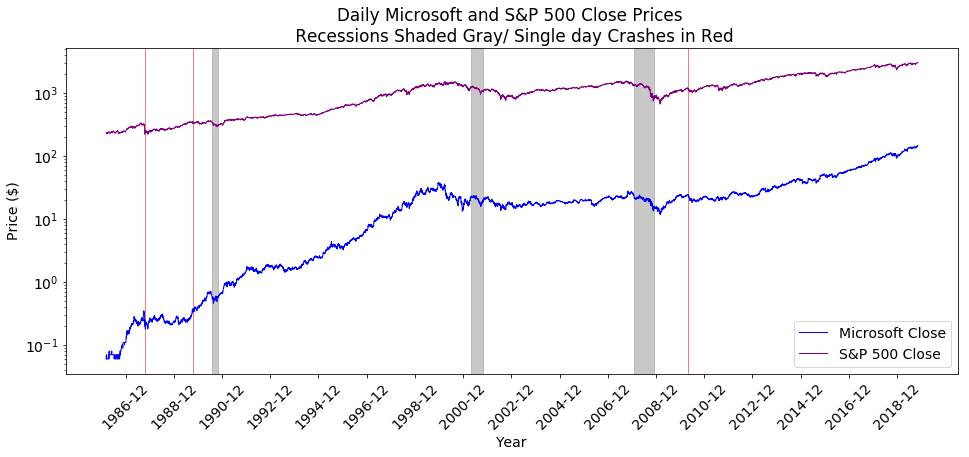

In [29]:
plt.figure(figsize = (16,6), linewidth=3, frameon = False)
scale = "log" #using log scale to better visualize both stock and index since the total values are very different

#Microsoft
plot_stock_data(msft_data.close, "Microsoft Close", "blue", scale)

#S&P 500
plot_stock_data(spy_500.close, "S&P 500 Close", "purple", scale)

#Recessions and single day crashes
show_important_events(msft_data)

plt.title("Daily Microsoft and S&P 500 Close Prices \n Recessions Shaded Gray/ Single day Crashes in Red")

plt.show()

The plot above has some interesting additions. The three gray areas are three recession periods in the United States during the period we have stock data for. The data is obtained from [FRED](https://fred.stlouisfed.org/series/JHDUSRGDPBR) and is based on a mathematical model of the way that recessions differ from expansions (according to the information provided on the website). The red lines, on the other hand, provide information about single-day crashes of the stock markets:
- [Black Monday: Oct 19, 1987](https://en.wikipedia.org/wiki/Black_Monday_(1987))
- [Black Friday: Oct 13, 1989](https://en.wikipedia.org/wiki/Friday_the_13th_mini-crash)
- [Flash Crash: May 6, 2010](https://en.wikipedia.org/wiki/2010_Flash_Crash )

In [30]:
#plot with a drop-down menu to switch between datasets
@interact(control=widgets.Dropdown(
    options=["msft_data",
             "spy_500",
             #"nasdaq"
             ],
    description='Datasets'
))

def plot_df(control):
    #plt.figure(figsize = (16,6), linewidth=3, frameon = False)
    data = eval(control)
    plot_data(data)

interactive(children=(Dropdown(description='Datasets', options=('msft_data', 'spy_500'), value='msft_data'), O…

The interactive plot above gives us the opportunity to examine our datasets closer. For example, it is easy to notice how long term price trends change when compare closing prices with a moving average of 200.   

The single-day crashes which we marked in red in the first plots are events that we will treat as outliers. The sharp negative changes in the prices occur during a single period (a day, or even less). The stock/index behavior is unusual, compared to the whole dataset. This could affect our models (regression models do not like outliers), this is why we will remove these observations from our data.

In [31]:
#remove single day crashes
msft_data = msft_data.drop([pd.to_datetime('2010-5-6'), pd.to_datetime('1989-10-13'), pd.to_datetime('1987-10-19')])
spy_500 = spy_500.drop([pd.to_datetime('2010-5-6'), pd.to_datetime('1989-10-13'), pd.to_datetime('1987-10-19')])

In [32]:
msft_data["daily_log_return_msft"] = calculate_log_return(msft_data.close, msft_data.open)
msft_data["daily_return"] = calculate_return(msft_data.close, msft_data.open)

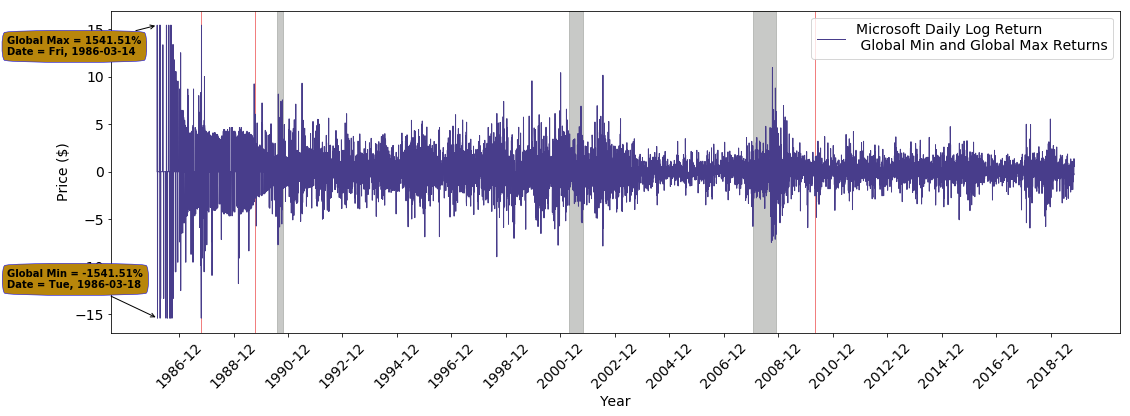

In [33]:
#show max and min returns for the whole dataset
scale = "linear"
plt.figure(figsize = (16,6), linewidth=3, frameon = False)
plot_stock_data(msft_data.daily_log_return_msft, 
                "Microsoft Daily Log Return\n Global Min and Global Max Returns", "darkslateblue", scale)
show_important_events(msft_data)
show_max_min_return(msft_data, "daily_log_return_msft")

In [34]:
spy_500["daily_log_return_spy"] = calculate_log_return(spy_500.close, spy_500.open)
spy_500["daily_return"] = calculate_return(spy_500.close, spy_500.open)

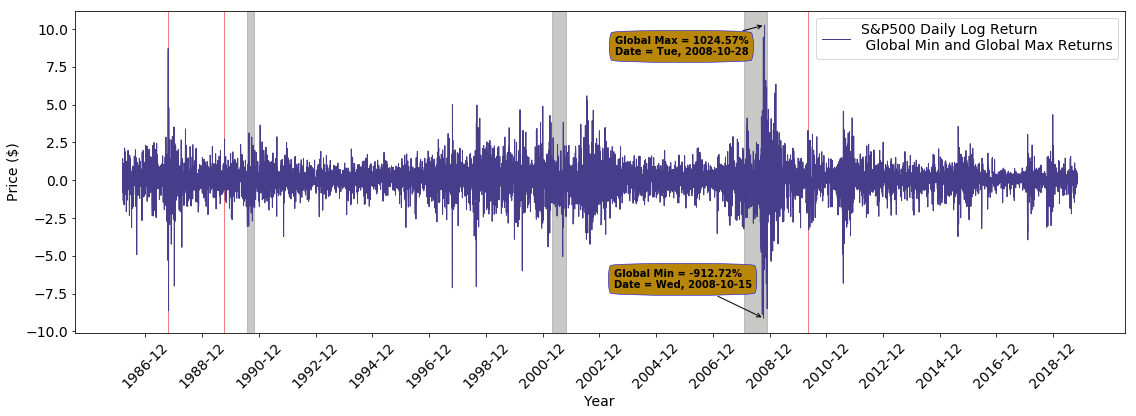

In [35]:
scale = "linear"
plt.figure(figsize = (16,6), linewidth=3, frameon = False)
plot_stock_data(spy_500.daily_log_return_spy, 
                "S&P500 Daily Log Return\n Global Min and Global Max Returns", "darkslateblue", scale)
show_important_events(spy_500)
show_max_min_return(spy_500, "daily_log_return_spy")

In [36]:
#Get our risk-free rate
three_month_treasury = pd.read_csv("three_month_treasury.csv")

In [37]:
three_month_treasury.head()

Date  Value
0  1954-01-04   1.33
1  1954-01-05   1.28
2  1954-01-06   1.28
3  1954-01-07   1.31
4  1954-01-08   1.31

In [38]:
three_month_treasury = set_date_index(three_month_treasury)

In [39]:
three_month_treasury = three_month_treasury.rename(columns = {"Value": "value"})

In [40]:
three_month_treasury.shape

(16456, 1)

In [41]:
#three_month_treasury.index.year.unique()

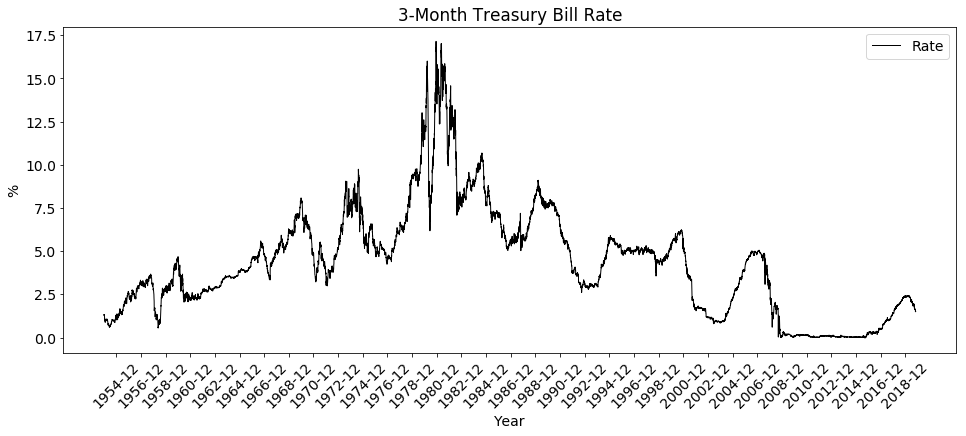

In [42]:
plt.figure(figsize = (16,6), linewidth=3, frameon = False)
plt.title("3-Month Treasury Bill Rate")
plot_stock_data(three_month_treasury.value, "Rate", "black", "linear")
plt.ylabel("%")
plt.show()

In [43]:
#add a major commodity. in our case oil
crude_oil_futures = pd.read_csv("crude_oil_futures.csv")

In [44]:
crude_oil_futures.tail()
#settle equals closing price for the day

Date   Open   High    Low   Last  Change  Settle    Volume  \
9199  2019-11-06  57.26  57.85  56.11  56.39    0.88   56.35  606612.0   
9200  2019-11-07  56.35  57.88  56.27  57.07    0.80   57.15  665028.0   
9201  2019-11-08  57.08  57.48  55.76  57.45    0.09   57.24  618762.0   
9202  2019-11-11  57.40  57.40  56.25  56.90    0.38   56.86  486317.0   
9203  2019-11-12  56.89  57.55  56.54  56.78    0.06   56.80  569382.0   

      Previous Day Open Interest  
9199                    396036.0  
9200                    371300.0  
9201                    352155.0  
9202                    317237.0  
9203                    280384.0

In [45]:
crude_oil_futures = set_date_index(crude_oil_futures)
crude_oil_futures.sample()

Open   High    Low  Last  Change  Settle    Volume  \
Date                                                              
2010-03-18  82.85  82.85  81.68  82.2     NaN    82.2  208343.0   

            Previous Day Open Interest  
Date                                    
2010-03-18                     52698.0

In [46]:
crude_oil_futures = crude_oil_futures.loc[crude_oil_futures.index > '1986-03-12']

In [47]:
crude_oil_futures.shape

(8464, 8)

In [48]:
crude_oil_futures["daily_log_return_oil"] = calculate_log_return(crude_oil_futures.Settle, crude_oil_futures.Open)
crude_oil_futures["daily_return"] = calculate_return(crude_oil_futures.Settle, crude_oil_futures.Open)

In [49]:
crude_oil_futures.sample()

Open   High    Low   Last  Change  Settle   Volume  \
Date                                                              
2003-01-03  32.15  33.25  32.08  33.08     NaN   33.08  68416.0   

            Previous Day Open Interest  daily_log_return_oil  daily_return  
Date                                                                        
2003-01-03                    176486.0              2.851642      2.892691

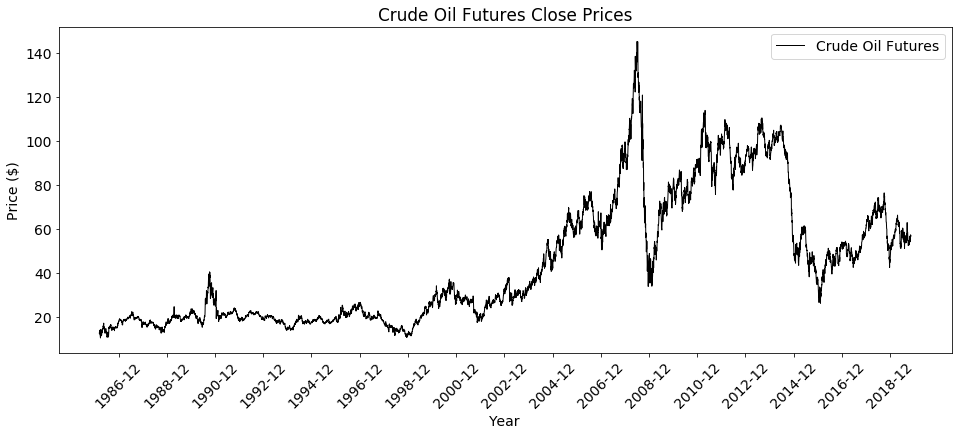

In [50]:
plt.figure(figsize = (16,6), linewidth=3, frameon = False)
plt.title("Crude Oil Futures Close Prices")
plot_stock_data(crude_oil_futures.Settle, "Crude Oil Futures", "black", "linear")
plt.show()

Since we don't have data for the EUR/USD exchange rate prior to 1999 (because euro did not exist back then, if you wanna know :) ) we had to substitute it with the equivalent - ECU and concatenate it with the data for the exchange rate after this year. The observations for the ECU are on a monthly basis which is a problem. We dealt with it by filling in the Nan's with the nearest non-nan values. 

In [51]:
ecu_to_usd = pd.read_csv("ecu_to_usd_data.csv")
ecu_to_usd = ecu_to_usd.rename(columns = {
    "DATE": "Date",
    "EXUSEC": "value"})

In [52]:
ecu_to_usd.head()

Date   value
0  1978-12-01  1.3773
1  1979-01-01  1.3583
2  1979-02-01  1.3517
3  1979-03-01  1.3520
4  1979-04-01  1.3370

In [53]:
euro_usd_exchange_rate = pd.read_csv("eur_usd_data.csv")
euro_usd_exchange_rate = euro_usd_exchange_rate.rename(columns = {
    "DATE": "Date",
    "Value": "value"})
euro_usd_exchange_rate.head()

Date   value
0  1999-01-04  1.1789
1  1999-01-05  1.1790
2  1999-01-06  1.1743
3  1999-01-07  1.1632
4  1999-01-08  1.1659

In [54]:
ecu_to_usd = set_date_index(ecu_to_usd)
euro_usd_exchange_rate = set_date_index(euro_usd_exchange_rate)

In [55]:
euro_usd_exchange_rate.head()

value
Date              
1999-01-04  1.1789
1999-01-05  1.1790
1999-01-06  1.1743
1999-01-07  1.1632
1999-01-08  1.1659

In [57]:
start_date = ecu_to_usd.index.min() - pd.DateOffset(day=1)
end_date = ecu_to_usd.index.max() + pd.DateOffset(day=31)

In [58]:
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
ecu_to_usd = ecu_to_usd.reindex(dates, method='nearest')

In [59]:
ecu_to_usd.shape

(7336, 1)

In [60]:
ecu_to_usd.tail()

value
date              
1998-12-27  1.1756
1998-12-28  1.1756
1998-12-29  1.1756
1998-12-30  1.1756
1998-12-31  1.1756

In [61]:
eur_ecu_combined = pd.concat([ecu_to_usd,euro_usd_exchange_rate], ignore_index=False)
eur_ecu_combined.sample()

value
1994-10-21  1.2374

In [62]:
eur_ecu_combined = eur_ecu_combined.loc[eur_ecu_combined.index > '1986-03-12']

In [63]:
eur_ecu_combined.shape

(10019, 1)

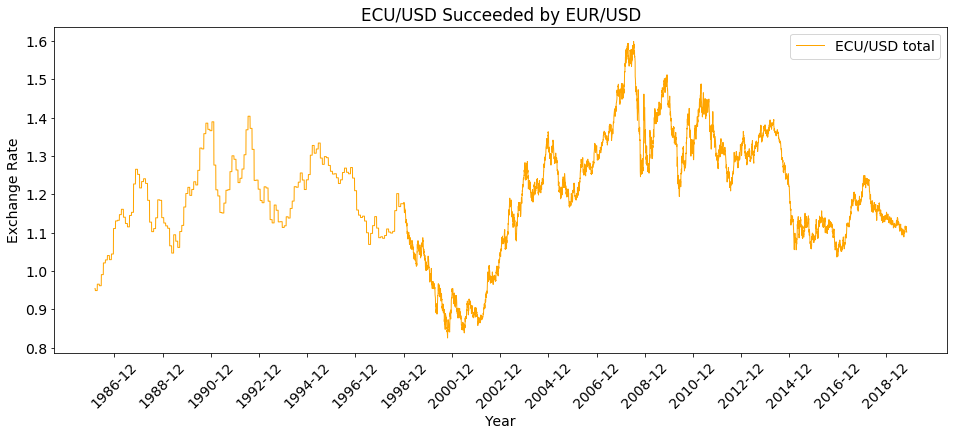

In [64]:
#U.S. Dollars to One Euro Community Unit/Euro
plt.figure(figsize = (16,6), linewidth=3, frameon = False)
plt.title("ECU/USD Succeeded by EUR/USD")
plot_stock_data(eur_ecu_combined,"ECU/USD total", "orange", "linear")
plt.ylabel("Exchange Rate")
plt.show()

In [65]:
#since we don't need a timeframe from the period before MSFT IPO it is time to cut
three_month_treasury = three_month_treasury.loc[three_month_treasury.index > '1986-03-12']

In [66]:
#calculate excess return - the forecasted variable
msft_data = pd.concat([msft_data, three_month_treasury], axis = 1)

In [67]:
df1 = msft_data[msft_data.isna().any(axis=1)]

In [68]:
#all of these are holidays too
df1.index.unique()

DatetimeIndex(['1986-03-13', '1986-03-14', '1986-03-17', '1986-03-18',
               '1986-03-19', '1986-03-20', '1986-03-21', '1986-03-24',
               '1986-03-25', '1986-03-26',
               ...
               '2015-10-12', '2015-11-11', '2016-10-10', '2016-11-11',
               '2017-10-09', '2018-10-08', '2018-11-12', '2019-10-14',
               '2019-11-11', '2019-11-12'],
              dtype='datetime64[ns]', name='Date', length=285, freq=None)

The above list does not look good at first. But after observation of the dates, things got clearer. The dates are different holidays in the USA. It looks like the U.S. Treasury is having a bit different holiday schedule than the Stock Exchange. So it is possible to have rates from one or the other. For this reason the best choice here will be to remove the holiday rows.

In [69]:
df1.shape

(285, 13)

In [70]:
msft_data.shape

(8498, 13)

In [71]:
msft_data.dropna(axis=0, inplace = True)

In [72]:
msft_data.shape

(8213, 13)

#### Calculation of the risk premium
This will be our target column when we start applying ML models

In [73]:
msft_data["risk_premium"] = msft_data.daily_log_return_msft - msft_data.value

In [74]:
msft_data.head()

open  high   low  close      volume  dividends  stock_splits  \
Date                                                                       
1986-12-24  0.11  0.11  0.11   0.11   7027200.0        0.0           0.0   
1986-12-26  0.11  0.11  0.11   0.11   3715200.0        0.0           0.0   
1986-12-29  0.11  0.11  0.11   0.11  41702400.0        0.0           0.0   
1986-12-30  0.11  0.11  0.10   0.11  25401600.0        0.0           0.0   
1986-12-31  0.11  0.11  0.11   0.11  23356800.0        0.0           0.0   

            rolmean_20  rolmean_50  rolmean_200  daily_log_return_msft  \
Date                                                                     
1986-12-24       0.109      0.0988      0.07545                    0.0   
1986-12-26       0.109      0.0994      0.07570                    0.0   
1986-12-29       0.109      0.1000      0.07590                    0.0   
1986-12-30       0.109      0.1006      0.07610                    0.0   
1986-12-31       0.109      0.1012      0.07635                    0.0   

            daily_return  value  risk_premium  
Date                                           
1986-12-24           0.0   5.57         -5.57  
1986-12-26           0.0   5.57         -5.57  
1986-12-29           0.0   5.67         -5.67  
1986-12-30           0.0   5.69         -5.69  
1986-12-31           0.0   5.67         -5.67

#### The final data set contains four predictors and one target

In [75]:
final_dataset_for_ml = pd.concat([msft_data.volume,
                                  spy_500.daily_log_return_spy,
                                  crude_oil_futures.daily_log_return_oil,
                                  eur_ecu_combined.value,
                                  msft_data.risk_premium], axis = 1, ignore_index=False)

In [76]:
final_dataset_for_ml = final_dataset_for_ml.rename(columns = {
        "value": "EUR_USD_exchange_rate"})

In [77]:
final_dataset_for_ml.dtypes

volume                   float64
daily_log_return_spy     float64
daily_log_return_oil     float64
EUR_USD_exchange_rate    float64
risk_premium             float64
dtype: object

In [78]:
final_dataset_for_ml.index.dtype

dtype('<M8[ns]')

In [79]:
final_dataset_for_ml.head()

volume  daily_log_return_spy  daily_log_return_oil  \
1986-03-13     NaN              0.279132            -10.851758   
1986-03-14     NaN              1.430603             -0.626961   
1986-03-15     NaN                   NaN                   NaN   
1986-03-16     NaN                   NaN                   NaN   
1986-03-17     NaN             -0.797933              5.448819   

            EUR_USD_exchange_rate  risk_premium  
1986-03-13                 0.9540           NaN  
1986-03-14                 0.9540           NaN  
1986-03-15                 0.9540           NaN  
1986-03-16                 0.9540           NaN  
1986-03-17                 0.9489           NaN

In [80]:
final_dataset_for_ml.dropna(inplace = True)

In [81]:
final_dataset_for_ml.shape

(8132, 5)

In [82]:
final_dataset_for_ml.head()

volume  daily_log_return_spy  daily_log_return_oil  \
1986-12-24   7027200.0              0.166298              1.693471   
1986-12-29  41702400.0             -0.907303              1.426558   
1986-12-30  25401600.0             -0.528657              0.397389   
1986-12-31  23356800.0             -0.494296              0.502935   
1987-01-02  12643200.0              1.751917              1.276731   

            EUR_USD_exchange_rate  risk_premium  
1986-12-24                 1.1108         -5.57  
1986-12-29                 1.1108         -5.67  
1986-12-30                 1.1108         -5.69  
1986-12-31                 1.1108         -5.67  
1987-01-02                 1.1108         -5.55

In [83]:
final_dataset_for_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8132 entries, 1986-12-24 to 2019-11-08
Data columns (total 5 columns):
volume                   8132 non-null float64
daily_log_return_spy     8132 non-null float64
daily_log_return_oil     8132 non-null float64
EUR_USD_exchange_rate    8132 non-null float64
risk_premium             8132 non-null float64
dtypes: float64(5)
memory usage: 381.2 KB


In [84]:
#plot the data we will be working with in the forecasting models
def plot_final_data(df):    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['volume'],
                    name="Microsoft Daily Traded Volume",
                    line_color='blueviolet',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['daily_log_return_spy'],
                    name="S&P 500 daily return",
                    line_color='green',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['daily_log_return_oil'],
                    name="Crude oil daily return",
                    line_color='darkkhaki',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['EUR_USD_exchange_rate'],
                    name="EUR/USD exchange rate",
                    line_color='darkgoldenrod',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=df.index,
                    y=df['risk_premium'],
                    name="Target value: Risk premium",
                    line_color='brown',
                    opacity=0.8))

    # Use date string to set xaxis range
    fig.update_layout(title_text='Explore data',
                  xaxis_rangeslider_visible=True)
    fig.show()
    
plot_final_data(final_dataset_for_ml)

Above - the return that we can expect from MSFT does not exceed the market in the long run. What a surprise :D 

##  Lies, damned lies, and statistics :) 

In [85]:
@interact(control=widgets.Dropdown(
    options=["volume",
             "daily_log_return_spy",
             "daily_log_return_oil",
             "EUR_USD_exchange_rate",
             "risk_premium"],
    description='Columns'
))

def plot_df(control):
    data = eval('final_dataset_for_ml.{}'.format(control))
    #Dickey-Fuller test and rolling stats
    test_stationarity(data)

interactive(children=(Dropdown(description='Columns', options=('volume', 'daily_log_return_spy', 'daily_log_re…

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root. If it is close to significant, then we need to check the critical values to make a judgment about the null hypothesis.

The lines above mean that our null hypothesis is that the TS is non-stationary.

Since we still cannot come up with a better check stat for testing our hypotheses, we will have to trust (with a pinch of suspicion) the p-value. In our case, the p-value is significantly below the 0.05 significance level for the predictors: volume, daily log-returns of S&P500 and oil and we can reject the null hypothesis for these features.
This is not the case for the EUR/USD exchange rate and the target value. We will need to work on this issue and make all non-stationary data stationary before we proceed with the machine learning algorithms for prediction.

### shift()
Before we proceed with decomposing our data, there is one little thing we need to do - to make the time series "supervisable". What do we mean here? As we have already mentioned in the beginning, our purpose is to use ML algorithms to predict intraday returns. In order to do this, we need to make one little shift. The risk premium of Microsoft will be our target in the models so it needs to move one period ahead of its predictors. We will have to drop one NaN row but it is a justifiable act :)

In [86]:
final_dataset_for_ml.risk_premium = final_dataset_for_ml.risk_premium.shift(1, axis = 0) 

In [87]:
final_dataset_for_ml.head()

volume  daily_log_return_spy  daily_log_return_oil  \
1986-12-24   7027200.0              0.166298              1.693471   
1986-12-29  41702400.0             -0.907303              1.426558   
1986-12-30  25401600.0             -0.528657              0.397389   
1986-12-31  23356800.0             -0.494296              0.502935   
1987-01-02  12643200.0              1.751917              1.276731   

            EUR_USD_exchange_rate  risk_premium  
1986-12-24                 1.1108           NaN  
1986-12-29                 1.1108         -5.57  
1986-12-30                 1.1108         -5.67  
1986-12-31                 1.1108         -5.69  
1987-01-02                 1.1108         -5.67

In [88]:
final_dataset_for_ml = final_dataset_for_ml.dropna(axis = 0)

In [89]:
final_dataset_for_ml.info() #happy face

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8131 entries, 1986-12-29 to 2019-11-08
Data columns (total 5 columns):
volume                   8131 non-null float64
daily_log_return_spy     8131 non-null float64
daily_log_return_oil     8131 non-null float64
EUR_USD_exchange_rate    8131 non-null float64
risk_premium             8131 non-null float64
dtypes: float64(5)
memory usage: 381.1 KB


## Making data stationary

In [90]:
@interact(control=widgets.Dropdown(
    options=["volume",
             "daily_log_return_spy",
             "daily_log_return_oil",
             "EUR_USD_exchange_rate",
             "risk_premium"],
    description='Columns'
))

def plot_df(control):
    data = eval('final_dataset_for_ml.{}'.format(control))
    #Dickey-Fuller test and rolling stats
     
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    ax = sns.boxplot(x=pd.DatetimeIndex(data.index).year, y=data, ax = axes[0])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=True))    
    ax1 = sns.boxplot(x=pd.DatetimeIndex(data.index).month, y=data, ax = axes[1])    
    # Set Title
    axes[0].set_title('Year-wise Box Plot', fontsize=18); 
    axes[1].set_title('Month-wise Box Plot', fontsize=18)
    
    
    plt.show()

interactive(children=(Dropdown(description='Columns', options=('volume', 'daily_log_return_spy', 'daily_log_re…

We can see that in part of the columns we can detect cycles. But there are no signs of trend and seasonality, observed for volume, spy and oil return. 
On the other hand, we can see trend in the EUR/USD exchange rate and the risk premium. For the month of June, the exchange rate is visibly lower than the rest of the months of the year.

*Any time series may be split into the following components: Base Level + Trend + Seasonality + Error*

It is not mandatory that the all-time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

Let's observe a little bit more the columns that brought these suspicions on the table and check what we really have here.

*When we decompose our data additive decomposition will be used. Multiplicative seasonality, where our feature = Base level * Trend * Seasonality * Error, is not appropriate for zero and negative values, and since we are working with returns, both are possible.*

Below we use the seasonal_decompose function to split our non-stationary features to their elements. Since we did not observe the clear seasonal trend, we chose a *freq* parameter to be set to 10 (10 business days a.k.a 2 weeks) and to observe possible shorter patterns. 

Also, setting the * to extrapolate trend* = to 'freq' is a very good decision to make if you don't want to deal with NaN values and to dig for ways to interpolate data in the beginning and end of your data set.

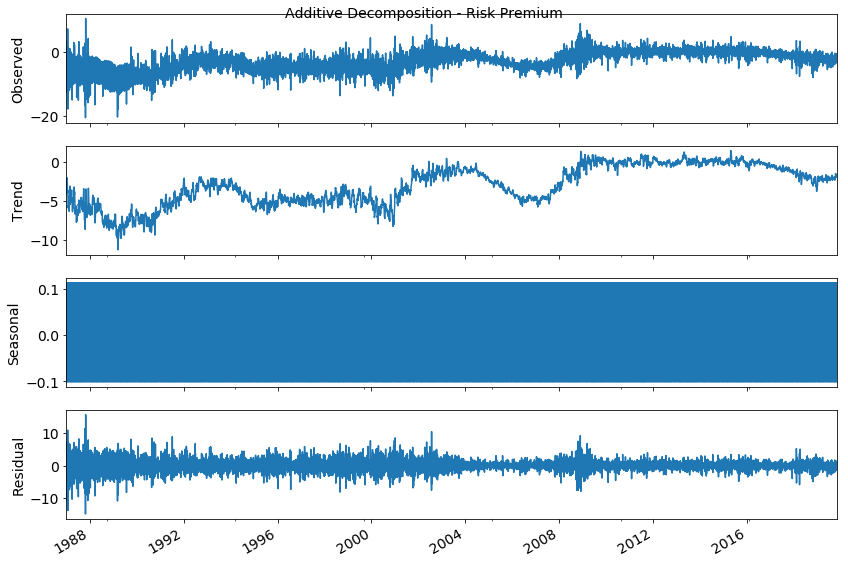

In [91]:
#Additive Decomposition Risk Premium
#Talk about trends and seasonality:
#Y_t = S_t + T_t + C_t + E_t

risk_premium_decompose = seasonal_decompose(
    final_dataset_for_ml.risk_premium,
    model='additive',
    freq = 10,
    extrapolate_trend="freq") 

plt.rcParams.update({'figure.figsize': (12,8)})
risk_premium_decompose.plot().suptitle("Additive Decomposition - Risk Premium", fontsize = 14)
plt.show()

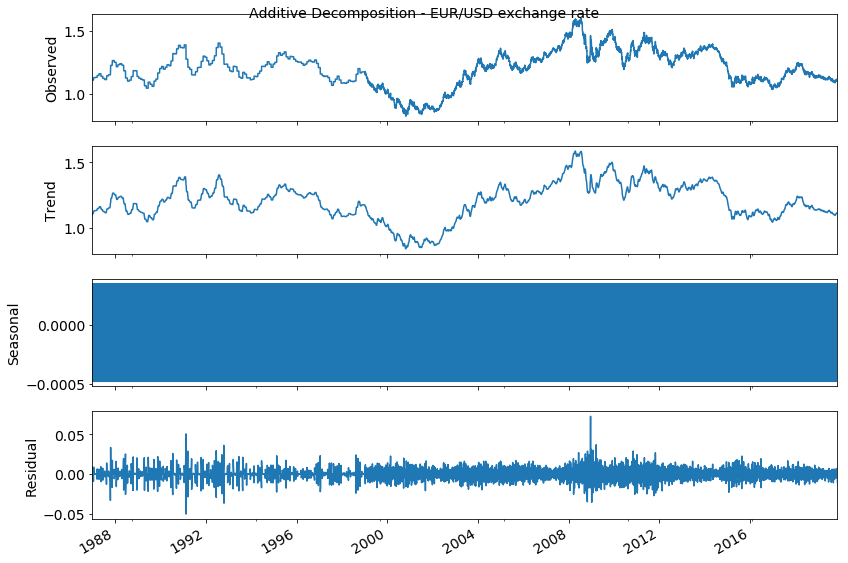

In [92]:
# Additive Decomposition EUR_USD exchange rate
EUR_USD_rate_decompose = seasonal_decompose(
    final_dataset_for_ml.EUR_USD_exchange_rate,
    model='additive',
    freq = 10,
    extrapolate_trend="freq")

plt.rcParams.update({'figure.figsize': (12,8)})
EUR_USD_rate_decompose.plot().suptitle("Additive Decomposition - EUR/USD exchange rate", fontsize = 14)
plt.show()

Before we check our data for stationarity again, we will put the data in tables, so we can access it easier later on.

In [93]:
risk_premium_deconstructed = pd.concat([risk_premium_decompose.seasonal,
                                        risk_premium_decompose.trend,
                                        risk_premium_decompose.resid
                                        ], axis=1)
risk_premium_deconstructed.columns = ['risk_premium_seas',
                                      'risk_premium_trend',
                                      'risk_premium_resid'
                                      ]

In [94]:
risk_premium_deconstructed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8131 entries, 1986-12-29 to 2019-11-08
Data columns (total 3 columns):
risk_premium_seas     8131 non-null float64
risk_premium_trend    8131 non-null float64
risk_premium_resid    8131 non-null float64
dtypes: float64(3)
memory usage: 574.1 KB


In [95]:
EUR_USD_rate_deconstructed = pd.concat([EUR_USD_rate_decompose.seasonal,
                                        EUR_USD_rate_decompose.trend,
                                        EUR_USD_rate_decompose.resid
                                        ], axis=1)
EUR_USD_rate_deconstructed.columns = ['EUR_USD_rate_seas',
                                      'EUR_USD_rate_trend',
                                      'EUR_USD_rate_resid'
                                      ]

In [96]:
EUR_USD_rate_deconstructed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8131 entries, 1986-12-29 to 2019-11-08
Data columns (total 3 columns):
EUR_USD_rate_seas     8131 non-null float64
EUR_USD_rate_trend    8131 non-null float64
EUR_USD_rate_resid    8131 non-null float64
dtypes: float64(3)
memory usage: 574.1 KB


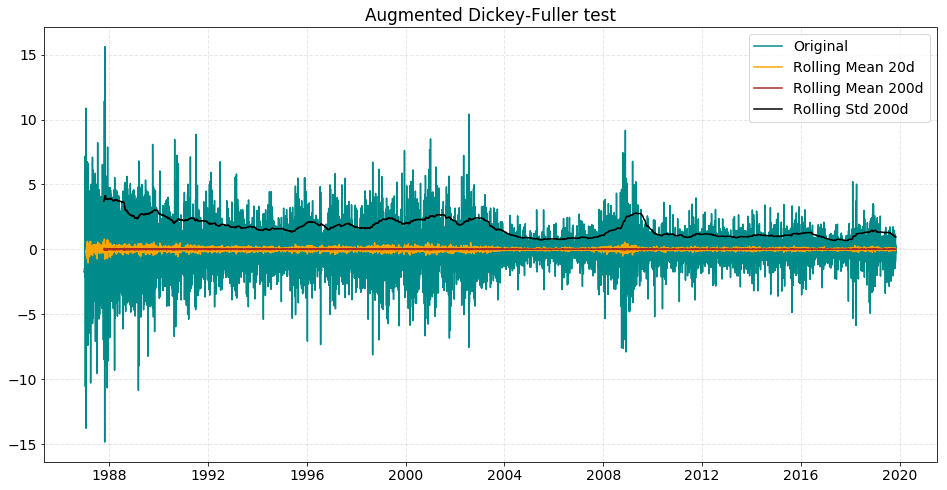

Results of Dickey-Fuller Test:
Test Statistic                  -28.940211
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8093.000000
Critical Value (1%)              -3.431158
Critical Value (5%)              -2.861897
Critical Value (10%)             -2.566960
dtype: float64


In [97]:
test_stationarity(risk_premium_decompose.resid)

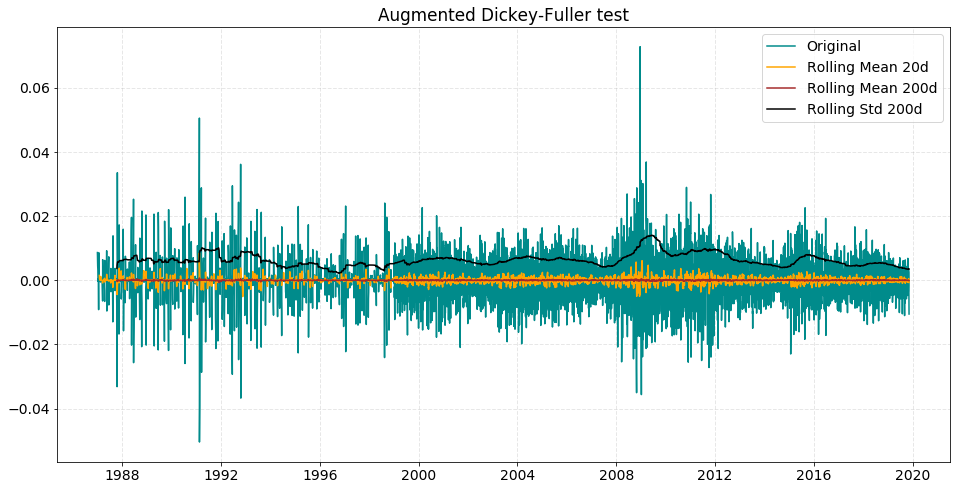

Results of Dickey-Fuller Test:
Test Statistic                  -23.449226
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    8095.000000
Critical Value (1%)              -3.431158
Critical Value (5%)              -2.861897
Critical Value (10%)             -2.566960
dtype: float64


In [98]:
test_stationarity(EUR_USD_rate_decompose.resid)

#happy me

Could it be better? The p-value for both attributes is below 0.05 level of significance, it is so close to zero we don't see it. Could this be a signal for a problem? We will see after some ML processing. For now, this p-value means we can reject the null hypothesis that there is a unit root in the data. Of course, we cannot be sure that the data is stationary but since we do not have another way to check it, we will assume stationarity. Thus, we will be able to continue with our first ML model.
but before that, we need to make some final corrections to our data.

We will add the residual columns to the final data set. For the Linear regression, we will actually work with these and not with the original values.

In [99]:
final_dataset_for_ml['exchange_rate_residual'] = EUR_USD_rate_deconstructed.EUR_USD_rate_resid
final_dataset_for_ml['risk_premium_residual'] = risk_premium_deconstructed.risk_premium_resid

In [100]:
#final_dataset_for_ml.info()
final_dataset_for_ml.head()
#final_dataset_for_ml.tail()

volume  daily_log_return_spy  daily_log_return_oil  \
1986-12-29  41702400.0             -0.907303              1.426558   
1986-12-30  25401600.0             -0.528657              0.397389   
1986-12-31  23356800.0             -0.494296              0.502935   
1987-01-02  12643200.0              1.751917              1.276731   
1987-01-05  48499200.0              2.302364             -1.108045   

            EUR_USD_exchange_rate  risk_premium  exchange_rate_residual  \
1986-12-29                 1.1108         -5.57                0.008645   
1986-12-30                 1.1108         -5.67                0.007492   
1986-12-31                 1.1108         -5.69                0.006277   
1987-01-02                 1.1108         -5.67                0.004540   
1987-01-05                 1.1108         -5.55                0.003147   

            risk_premium_residual  
1986-12-29              -1.512283  
1986-12-30              -1.766126  
1986-12-31              -1.714423  
1987-01-02              -1.836757  
1987-01-05              -1.849387

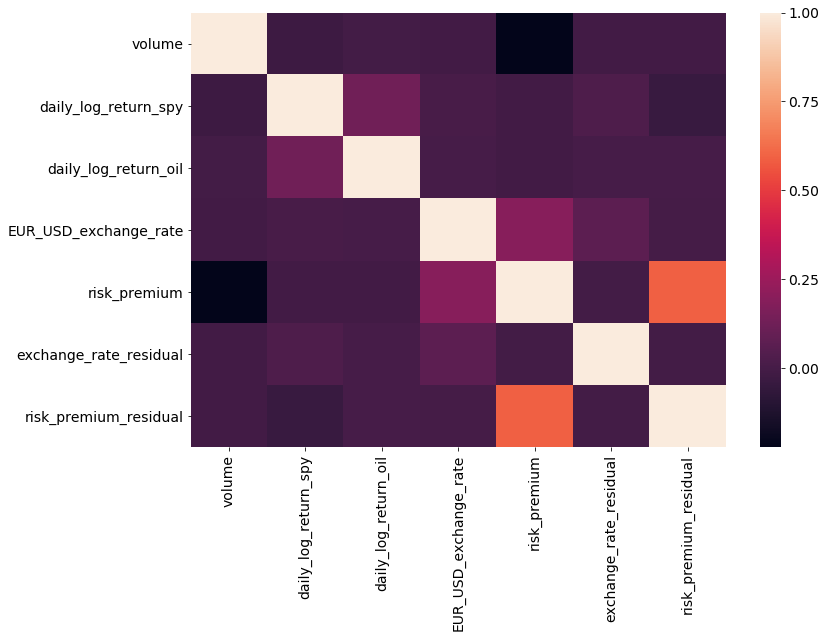

In [101]:
# Calculate correlations
corr = final_dataset_for_ml.corr()
 
# Heatmap
sns.heatmap(corr)
plt.show()

There is a strong correlation between risk_premium and its residual. But this will be no problem, since we will not use them together.

# Linear regression

In [102]:
#Get our predictors. We will use the stationarized data and will NOT leave the target in
return_predictors = final_dataset_for_ml.drop(["EUR_USD_exchange_rate",
                                               "risk_premium",
                                               "risk_premium_residual"], axis = 1)

In [103]:
#Prefferable to work in one scale
data_scaler = MinMaxScaler()

In [104]:
return_predictors_scaled = data_scaler.fit_transform(return_predictors)
return_predictors_scaled

array([[0.04840465, 0.42429948, 0.55220787, 0.47933547],
       [0.02763884, 0.44384453, 0.51597411, 0.46997426],
       [0.02503394, 0.4456182 , 0.51969004, 0.46011451],
       ...,
       [0.01639553, 0.47395217, 0.44558175, 0.37618813],
       [0.01793811, 0.46805531, 0.55161489, 0.36436598],
       [0.0165954 , 0.49091303, 0.51183826, 0.32374924]])

In [105]:
#target values to predict
target = final_dataset_for_ml.risk_premium_residual

In [106]:
#split data without shuffle. It is a time series, we don't shuffle time :) 
split_data = train_test_split(return_predictors_scaled, target, train_size = 0.7, test_size = 0.3, shuffle = False)
predictors_train, target_train = split_data[0], split_data[2]
predictors_test, target_test = split_data[1], split_data[3]

In [107]:
predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape

((5691, 4), (2440, 4), (5691,), (2440,))

In [108]:
model_linear_regression = LinearRegression()

In [109]:
model_linear_regression.fit(predictors_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [110]:
linear_regr_score_test = model_linear_regression.score(predictors_test, target_test)
linear_regr_score_test

0.005123366524733108

This does not look good. Actually, it is pretty bad.. A possible reason is that it is all noise what it's left after removing trend and seasonality. Or maybe we did not decomposed the data correctly. We used very small frequency value (10). We will try with freq = 200 (almost a whole business year).

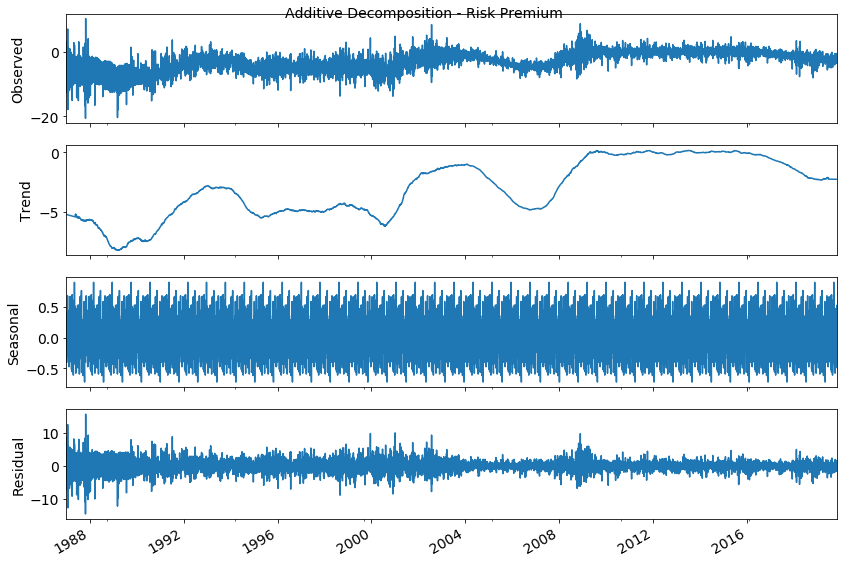

In [111]:
risk_premium_decompose = seasonal_decompose(
    final_dataset_for_ml.risk_premium,
    model='additive',
    freq = 200,
    extrapolate_trend="freq")

plt.rcParams.update({'figure.figsize': (12,8)})
risk_premium_decompose.plot().suptitle("Additive Decomposition - Risk Premium", fontsize = 14)
plt.show()

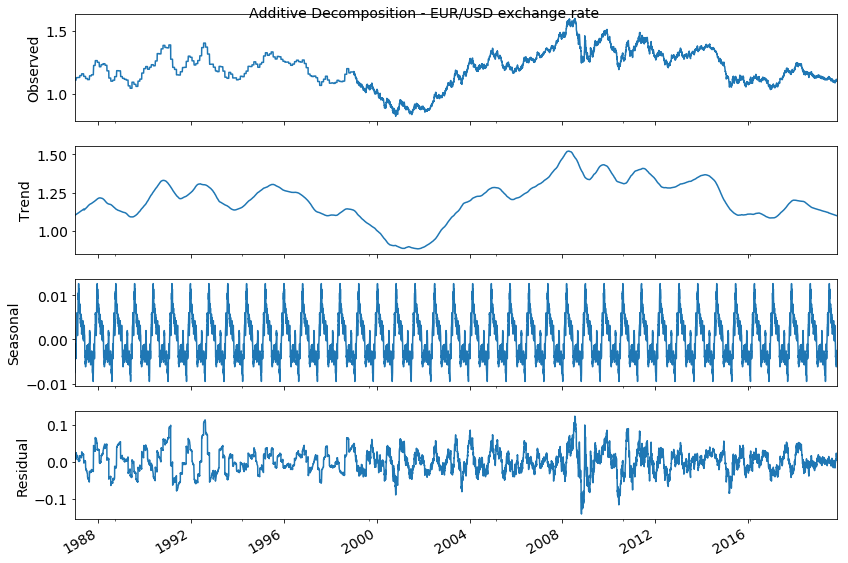

In [112]:
# Additive Decomposition
EUR_USD_rate_decompose = seasonal_decompose(
    final_dataset_for_ml.EUR_USD_exchange_rate,
    model='additive',
    freq = 200,
    extrapolate_trend="freq")

plt.rcParams.update({'figure.figsize': (12,8)})
EUR_USD_rate_decompose.plot().suptitle("Additive Decomposition - EUR/USD exchange rate", fontsize = 14)
plt.show()

In [113]:
risk_premium_deconstructed = pd.concat([risk_premium_decompose.seasonal,
                                        risk_premium_decompose.trend,
                                        risk_premium_decompose.resid
                                        ], axis=1)
risk_premium_deconstructed.columns = ['risk_premium_seas',
                                      'risk_premium_trend',
                                      'risk_premium_resid'
                                      ]
EUR_USD_rate_deconstructed = pd.concat([EUR_USD_rate_decompose.seasonal,
                                        EUR_USD_rate_decompose.trend,
                                        EUR_USD_rate_decompose.resid
                                        ], axis=1)
EUR_USD_rate_deconstructed.columns = ['EUR_USD_rate_seas',
                                      'EUR_USD_rate_trend',
                                      'EUR_USD_rate_resid'
                                      ]

In [114]:
final_dataset_for_ml['exchange_rate_residual'] = EUR_USD_rate_deconstructed.EUR_USD_rate_resid
final_dataset_for_ml['risk_premium_residual'] = risk_premium_deconstructed.risk_premium_resid

In [115]:
final_dataset_for_ml.head()

volume  daily_log_return_spy  daily_log_return_oil  \
1986-12-29  41702400.0             -0.907303              1.426558   
1986-12-30  25401600.0             -0.528657              0.397389   
1986-12-31  23356800.0             -0.494296              0.502935   
1987-01-02  12643200.0              1.751917              1.276731   
1987-01-05  48499200.0              2.302364             -1.108045   

            EUR_USD_exchange_rate  risk_premium  exchange_rate_residual  \
1986-12-29                 1.1108         -5.57                0.016614   
1986-12-30                 1.1108         -5.67                0.016170   
1986-12-31                 1.1108         -5.69                0.012354   
1987-01-02                 1.1108         -5.67                0.011258   
1987-01-05                 1.1108         -5.55                0.011794   

            risk_premium_residual  
1986-12-29              -0.504405  
1986-12-30              -0.404616  
1986-12-31              -0.235159  
1987-01-02              -0.383644  
1987-01-05              -0.262522

In [116]:
return_predictors = final_dataset_for_ml.drop(["EUR_USD_exchange_rate",
                                               "risk_premium",
                                               "risk_premium_residual"], axis = 1)

return_predictors_scaled = data_scaler.fit_transform(return_predictors)

target = final_dataset_for_ml.risk_premium_residual

split_data = train_test_split(return_predictors_scaled, target, train_size = 0.7, test_size = 0.3, shuffle = False)
predictors_train, target_train = split_data[0], split_data[2]
predictors_test, target_test = split_data[1], split_data[3]

In [117]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(predictors_train, target_train)
linear_regr_score_test = model_linear_regression.score(predictors_test, target_test)
linear_regr_score_test

-0.0039223445401133095

Not the happiest moment in my life when I try to fix something and it breaks even more...

In [118]:
risk_prem_seasonality_test = risk_premium_deconstructed.risk_premium_seas.tail(len(predictors_test))
risk_prem_trend_test = risk_premium_deconstructed.risk_premium_trend.tail(len(predictors_test))

In [119]:
#get predicted values
predicted_risk_premium = model_linear_regression.predict(predictors_test)

In [120]:
#add seasonality and trend
predicted_risk_premium_ST = predicted_risk_premium + risk_prem_seasonality_test + risk_prem_trend_test

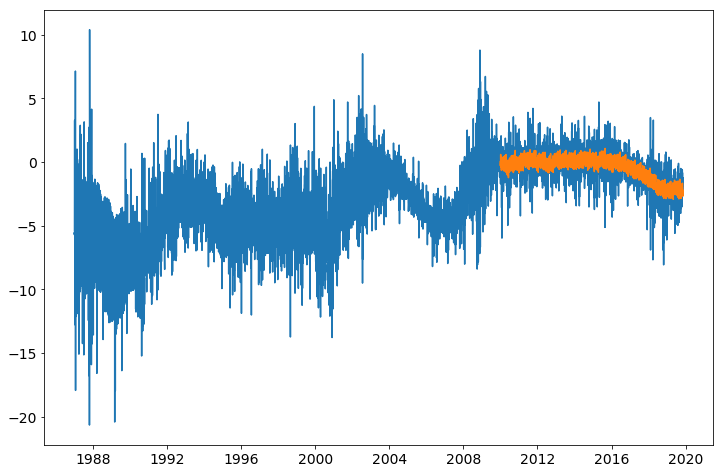

In [121]:
plt.plot(final_dataset_for_ml.risk_premium)
plt.plot(predicted_risk_premium_ST)
plt.show()

In [122]:
#risk_premium_original = final_dataset_for_ml.risk_premium.tail(len(predictors_test))
#plt.plot(risk_premium_original)
#plt.plot(predicted_risk_premium_ST)
#plt.show()

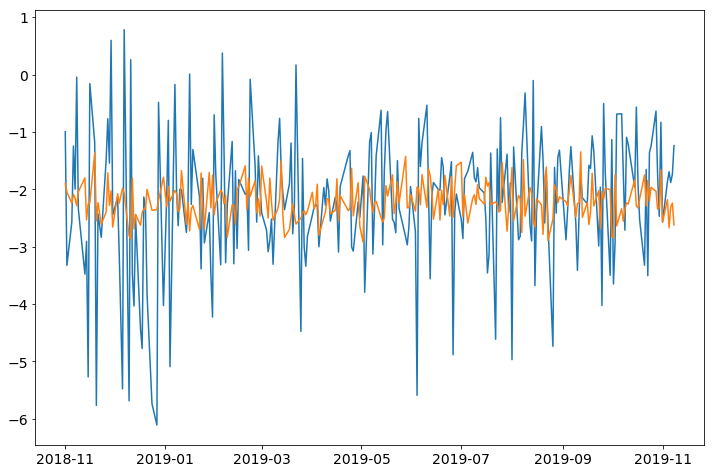

In [123]:
#zoom even more...
risk_premium_original = final_dataset_for_ml.risk_premium.tail(252)
predicted_risk_premium_ST = predicted_risk_premium_ST.tail(252)
plt.plot(risk_premium_original)
plt.plot(predicted_risk_premium_ST)
plt.show()

Our work so far proved one main important thing - risk premium modeling is not to be done with simple linear regression. It is highly incorrect. We are way far from the truth...

We will now model it with little modifications. Let's make some regularization. 

# Elastic Net 

*The elastic net involves two non-negative hyperparameters and includes two well-known regularizers as special cases. The l1_ratio = 0 case corresponds to the ridge and uses an absolute value, or \l1", parameter penalization. The fortunate geometry of the lasso sets coefficients on a subset of covariates to exactly zero. In this sense, the lasso imposes sparsity on the specification and can thus be thought of as a variable selection method. The l1_ratio = 1 case corresponds to lasso regression, which uses an l2 parameter penalization, that draws all coefficient estimates closer to zero but does not impose exact zeros anywhere. In this sense, Ridge is a shrinkage method that helps prevent coefficients from becoming unduly large in magnitude. For intermediate values of l1_ratio, the elastic net encourages simple models through both shrinkage and selection.*[<sup>10</sup>](#fn10)

In [124]:
#first lets define cross validation for time series
tscv = TimeSeriesSplit(n_splits=5) 

In [125]:
#now we need to set the params for the GridSearchCV
params = {
    "alpha": [1e-06, 1e-04, 1e-02, 1e+00, 1e+02, 1e+04, 1e+06], #alpha=0 is equivalent to an OLS, solved by the LinearRegression object
    "l1_ratio": [0, 0.25, 0.5, 0.75, 1],
    "max_iter": [1e+3, 1e+4]
}


In [126]:
grid_search = GridSearchCV(ElasticNet(), params, cv = tscv) 

In [127]:
grid_search.fit(predictors_train, target_train)

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4563.229653499352, tolerance: 0.9169542519680015

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6227.776892052408, tolerance: 1.2525288031383197

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7734.218421842263, tolerance: 1.5542627748823736

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10346.824966820079, tolerance: 2.07809

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11414.790833069797, tolerance: 2.283011783049549

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4584.677303244621, tolerance: 0.9169542519680015

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6262.320470731518, tolerance: 1.2525288031383197

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7770.993928464611, tolerance: 1.554262

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7771.313874087756, tolerance: 1.5542627748823736

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10390.474392093385, tolerance: 2.0780948785178697

C:\Users\Az\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11415.058914976256, tolerance: 2.283011783049549



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-06, 0.0001, 0.01, 1.0, 100.0, 10000.0,
                                   1000000.0],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'max_iter': [1000.0, 10000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [128]:
grid_search.best_score_

-0.00016975549365223498

In [129]:
elastic_net_score_test = grid_search.best_estimator_.score(predictors_test, target_test)
elastic_net_score_test

-0.0004871763012237462

It got even worse than the no penalties model... This may be understandable since we have tried to regularize very few predictors which we are not sure are the best for the job we chose them to do, and no one guarantees us our logic to choose exactly these predictors is correct.

We will work with our original data and not with detrended versions because our next model can.

# ARIMA

In [130]:
#split data
target_train, target_test = train_test_split(final_dataset_for_ml.risk_premium, train_size = 0.7, test_size = 0.3, shuffle = False)
target_train, target_val = train_test_split(target_train, train_size = 0.6, test_size = 0.4, shuffle = False)
target_train.shape, target_val.shape, target_test.shape

((3414,), (2277,), (2440,))

This value of k is the time gap being considered and is called the lag. A lag 1 autocorrelation (i.e., k = 1 in the above) is the correlation between values that are one time period apart. More generally, a lag k autocorrelation is the correlation between values that are k time periods apart.

-> not accepting external data

**Examine acf and pacf for getting p and q values for ARIMA**

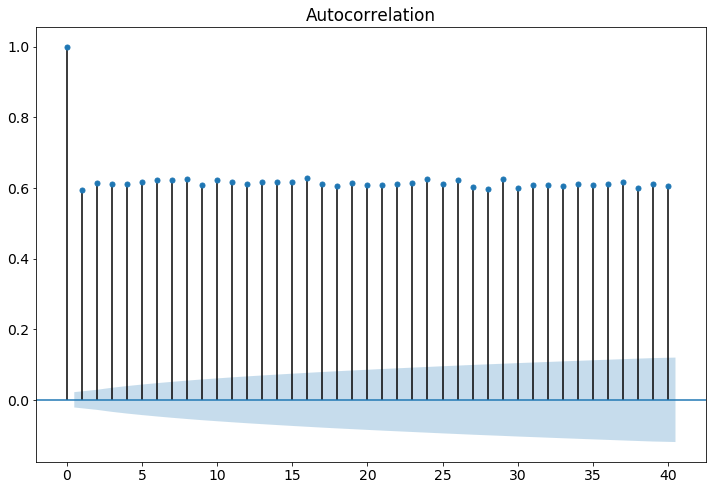

In [131]:
#move before ARIMA?   
sm.graphics.tsa.plot_acf(final_dataset_for_ml.risk_premium, fft = True) #for long time series
plt.show()

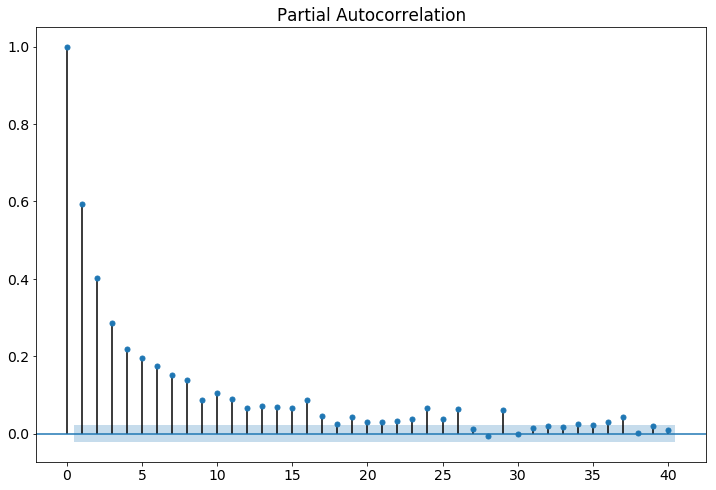

In [132]:
sm.graphics.tsa.plot_pacf(final_dataset_for_ml.risk_premium, lags=40)
plt.show()

The spike in lag 0 is to be ignored. Different packages choose to show it or not. We can see that the data is non-stationary starting with the [ACF]( https://stats.stackexchange.com/questions/234492/what-is-the-difference-between-period-cycle-and-seasonality). Differentiation will be definitely needed.

In [133]:
order_aic_arima = []
#now let's choose ARIMA based on AIC 
# Loop over AR order
p_values = [1, 2, 3]
d_values = [1]
q_values = [1, 2]
for p in p_values:
    for d in d_values:
        for q in q_values:
            model = ARIMA(target_train.values, order=(p,d,q))
            results = model.fit()
            order_aic_arima.append((p, d, q, results.aic))


In [134]:
arima_result = pd.DataFrame(order_aic_arima, columns=['p','d', 'q', 'AIC'])

In [135]:
arima_result = arima_result.sort_values('AIC')
arima_result.head()

p  d  q           AIC
1  1  1  2  15660.196492
3  2  1  2  15661.795221
4  3  1  1  15661.844828
5  3  1  2  15661.861887
0  1  1  1  15662.932129

### Best performance based on AIC - (p,d,q) = (1, 1, 2)
We will use the validation set now and the best order params to additionally tune the model in the fit method.
We will work with the "trend" param, which, as explained in the documentation, gives us the choice to include a constant or not. The latter can be explained as to add a bias in our model or not. 

By default, the "transparams" parameter transforms the parameters of the model to ensure stationarity. We are working with the original risk premium data which is not decomposed to trend/seasonality/residuals.

In [136]:
#validation with constant
model_val = ARIMA(target_val.values, order = (1,1,2))
results_val_c = model_val.fit(trend = 'c')

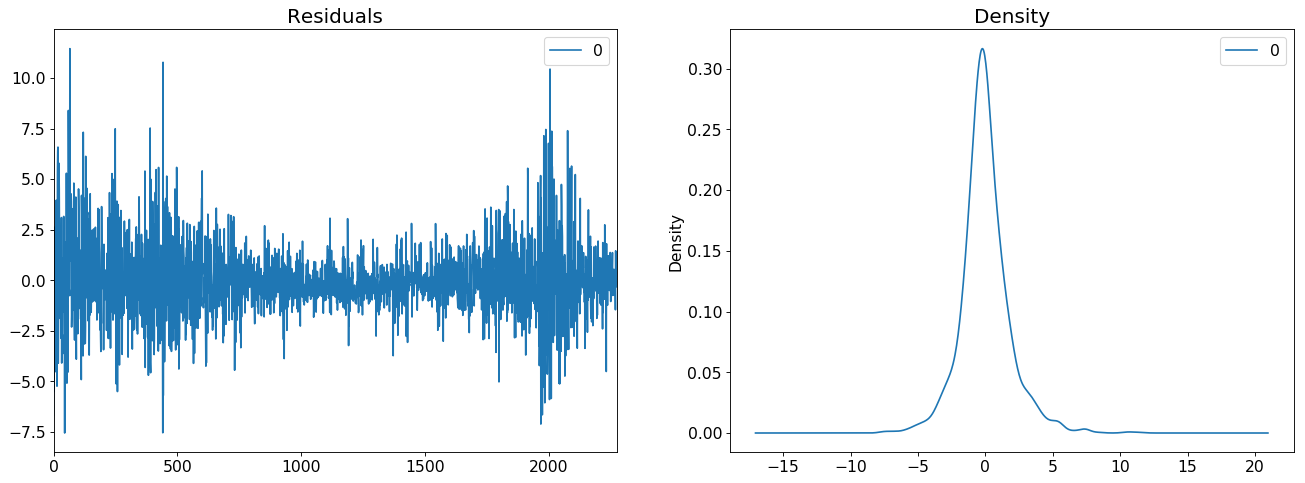

In [137]:
#Plot residual errors
residuals_c = pd.DataFrame(results_val_c.resid)
fig, ax = plt.subplots(1,2, figsize=(20,7), dpi= 80)
residuals_c.plot(ax = ax[0])
residuals_c.plot(kind = 'kde', ax = ax[1])
ax[0].set_title('Residuals', fontsize=18); 
ax[1].set_title('Density', fontsize=18)
plt.show()

The residuals don't seem random and the density is visibly leptokurtic. Leptokurtic distribution has a higher probability of extreme outlier values. If we look at our validation set we will see that it covers the period between the *[Early 2000s recession](https://en.wikipedia.org/wiki/Early_2000s_recession)* and the *[Housing bubble](https://en.wikipedia.org/wiki/Housing_bubble)* and the *[Financial crisis(2007-2008)](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008)* period and the extreme values at that time have serious impact on our data. We will plot our actual and predicted values to try to observe better.    

In [138]:
# Forecast, standard errors, confidence intervals
fc_c, se_c, conf_c = results_val_c.forecast(len(target_test), alpha=0.05)  # 95% conf

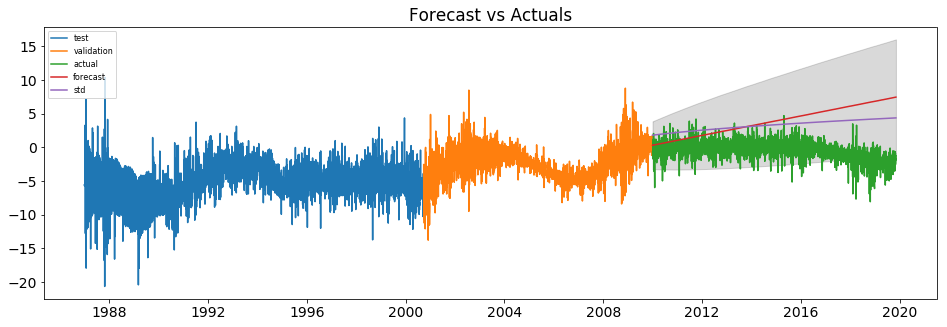

In [139]:
# Turn to pandas series
std_c = pd.Series(se_c, index = target_test.index)
forecast_series_c = pd.Series(fc_c, index=target_test.index)
lower_series_c = pd.Series(conf_c[:, 0], index=target_test.index)
upper_series_c = pd.Series(conf_c[:, 1], index=target_test.index)

# Plot
plt.figure(figsize=(16,5))
plt.plot(target_train, label='test')
plt.plot(target_val, label='validation')
plt.plot(target_test, label='actual')
plt.plot(forecast_series_c, label='forecast')
plt.plot(std_c, label = 'std')
plt.fill_between(lower_series_c.index, lower_series_c, upper_series_c, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Since we consider trend=constant here, the forecast is moving in the opposite direction of the trend of the actual value. 

Also, the plot clearly shows that our model needs to be forecasted with a walk-forward validation, to achieve more realistic values for our forecast. The process is really slow though and it will be a *TODO* note for further developing of the project.

Now let's fit our validation data without constant.

In [140]:
results_val_nc = model_val.fit(trend = 'nc')

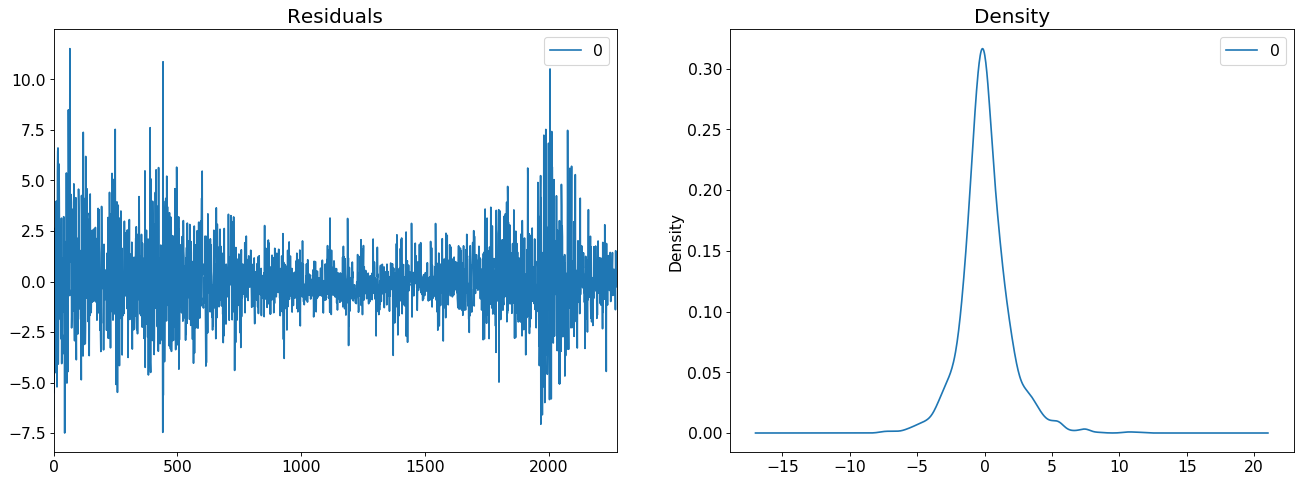

In [141]:
#Plot residual errors
residuals_nc = pd.DataFrame(results_val_nc.resid)
fig, ax = plt.subplots(1,2, figsize=(20,7), dpi= 80)
residuals_nc.plot(ax = ax[0])
residuals_nc.plot(kind = 'kde', ax = ax[1])
ax[0].set_title('Residuals', fontsize=18); 
ax[1].set_title('Density', fontsize=18)
plt.show()

In [142]:
# Forecast, standard errors, confidence intervals
fc_nc, se_nc, conf_nc = results_val_nc.forecast(len(target_test), alpha=0.05)  # 95% conf

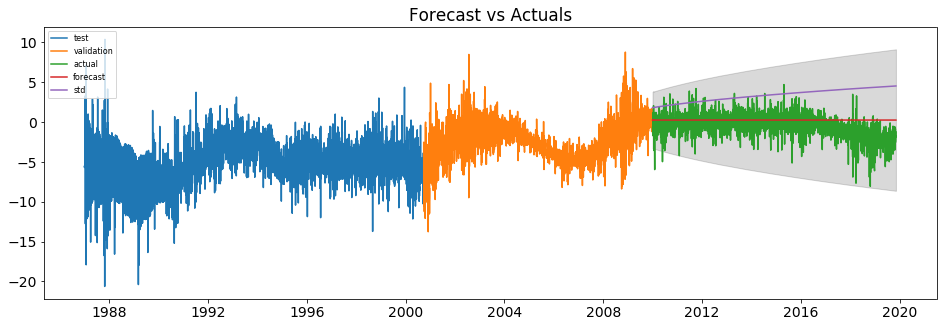

In [143]:
# Turn to pandas series
std_nc = pd.Series(se_nc, index = target_test.index)
forecast_series_nc = pd.Series(fc_nc, index=target_test.index)
lower_series_nc = pd.Series(conf_nc[:, 0], index=target_test.index)
upper_series_nc = pd.Series(conf_nc[:, 1], index=target_test.index)

# Plot
plt.figure(figsize=(16,5))
plt.plot(target_train, label='test')
plt.plot(target_val, label='validation')
plt.plot(target_test, label='actual')
plt.plot(forecast_series_nc, label='forecast')
plt.plot(std_nc, label = 'std')
plt.fill_between(lower_series_nc.index, lower_series_nc, upper_series_nc, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

This one actually looks slightly better. The forecasting line direction is closer to the one of the test set. But what we can do is actually change our p (AR) order from 1 to 2, to see if the forecast will change its direction further.

In [144]:
#validation with d = 2 and no constant
model_val = ARIMA(target_val.values, order = (2,1,2))

In [145]:
results_val_p2 = model_val.fit(trend = 'nc')

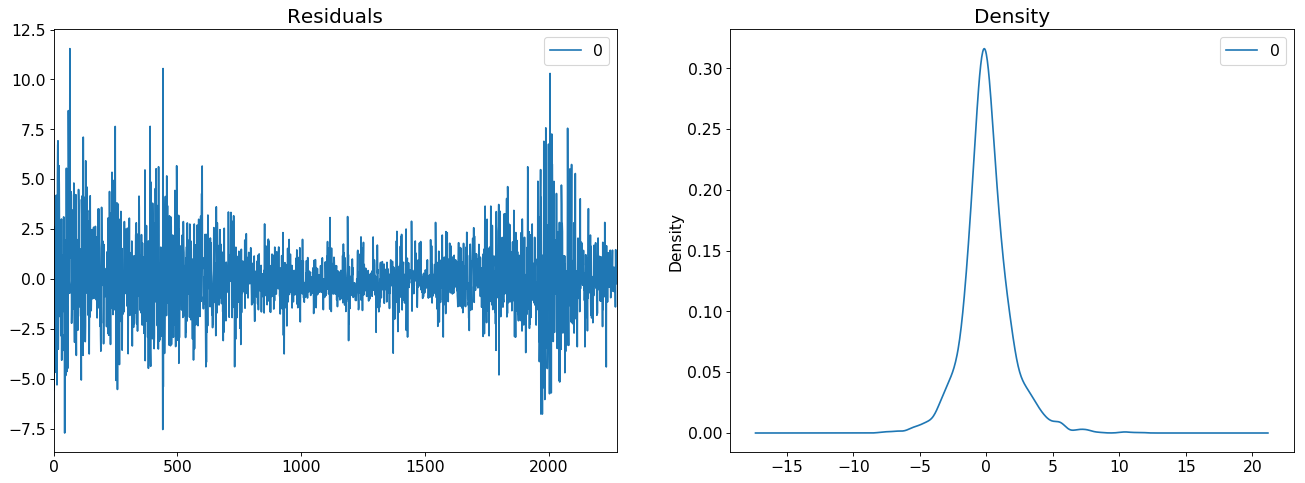

In [146]:
#Plot residual errors
residuals_p2 = pd.DataFrame(results_val_p2.resid)
fig, ax = plt.subplots(1,2, figsize=(20,7), dpi= 80)
residuals_p2.plot(ax = ax[0])
residuals_p2.plot(kind = 'kde', ax = ax[1])
ax[0].set_title('Residuals', fontsize=18); 
ax[1].set_title('Density', fontsize=18)
plt.show()

In [147]:
# Forecast, standard error of the forecast, confidence interval of the forecast
fc_p2, se_p2, conf_p2 = results_val_p2.forecast(len(target_test), alpha=0.05)  # 95% conf

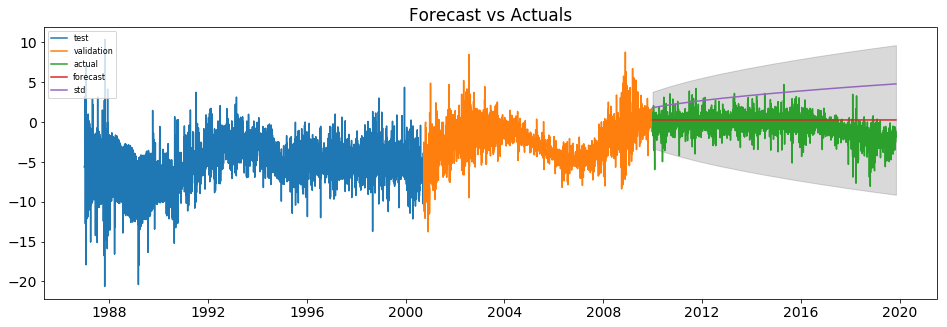

In [148]:
# Turn to pandas series
std_p2 = pd.Series(se_p2, index = target_test.index)
forecast_series_p2 = pd.Series(fc_p2, index=target_test.index)
lower_series_p2 = pd.Series(conf_p2[:, 0], index=target_test.index)
upper_series_p2 = pd.Series(conf_p2[:, 1], index=target_test.index)

# Plot
plt.figure(figsize=(16,5))
plt.plot(target_train, label='test')
plt.plot(target_val, label='validation')
plt.plot(target_test, label='actual')
plt.plot(forecast_series_p2, label='forecast')
plt.plot(std_p2, label = 'std')
plt.fill_between(lower_series_p2.index, lower_series_p2, upper_series_p2, 
                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Finally we will compare the performance of our models by calculating RMSE (one of the available metrics for this model).

In [149]:
#order = (1, 1, 2), trend = c
rmse = sqrt(mean_squared_error(target_test, forecast_series_c))
print('Test RMSE (order = (1, 1, 2), trend = c): %.3f' % rmse)

#order = (1, 1, 2), trend = nc
rmse = sqrt(mean_squared_error(target_test, forecast_series_nc))
print('Test RMSE (order = (1, 1, 2), trend = nc): %.3f' % rmse)
    
#order = (2, 1, 2), trend = nc
rmse = sqrt(mean_squared_error(target_test, forecast_series_p2))
print('Test RMSE (order = (2, 1, 2), trend = nc): %.3f' % rmse)

Test RMSE (order = (1, 1, 2), trend = c): 5.307
Test RMSE (order = (1, 1, 2), trend = nc): 1.591
Test RMSE (order = (2, 1, 2), trend = nc): 1.597


The best performing ARIMA model (*from all three bad models*) is the one we chose with AIC selection and removing trend constant. The possibilities for improving the model should continue from this point forward.

## Conclusions

For this project, our purpose was to use ML models for the prediction of daily risk premiums of stocks (MSFT in our case).

We have applied Linear Regression, Elastic Net and ARIMA.

The results were quite unsatisfactory (but not surprising) with the linear models where our scoring metric R^2 was close to 0 or even negative. The linear model is not the one to fit stock returns data. 

[AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) estimator proved to be a good starting point for choosing optimal p, d, q values. And removing the bias from the model proved to be another right step. But we failed to apply the model correctly by dynamically forecasting our data.


## Further improvements
1. Perform walk-forward validation for the ARIMA model
2. Use a new model - Exponential smoothing - 
Exponential smoothing is another way to forecast a time series. In this case, we assume that "the future will be more or less the same as the (recent) past. The only pattern that this model will be able to learn from demand history is its level."

The level is the average value around which the demand varies over time.

When using this method the weight that is put on each observation decrease exponentially over time. The closer we are to now the highest weight. This method is suitable for forecasting data with no clear trend or seasonal pattern. 
The simple exponential smoothing model has its limitations. It cannot deal with trends and seasonality, as well as with any external information. We can deal with trends and seasonality if we choose the Holt-Winters upgrade of the model.
3. Use ML models for monthly predictions of asset return where we will be able to include more predictors, such as P/E ratio and EPS ratio, etc. Applying Random Forest
5. Go into the Deep with Neural Networks

### Footnotes
<span id="fn1"> **1. ECU:** [Wikipedia](https://en.wikipedia.org/wiki/European_Currency_Unit) </span>

<span id="fn2"> **2.** [White Noise and Moving Average Models](http://people.stern.nyu.edu/churvich/Forecasting/Handouts/Chapt3.1.pdf) </span>

<span id="fn3"> **3.** [Stationarity and differencing](https://otexts.com/fpp2/stationarity.html) </span>

<span id="fn4"> **4.** [Market Business News](https://marketbusinessnews.com/financial-glossary/trend/) </span>

<span id="fn5"> **5.** [Cyclic and seasonal time series](https://robjhyndman.com/hyndsight/cyclicts/) </span>

<span id="fn6"> **6.** [Seasonality](https://www.investopedia.com/terms/s/seasonality.asp) </span>

<span id="fn7"> **7.** [Recession](https://www.investopedia.com/terms/r/recession.asp) </span>

<span id="fn8"> **8.** [Treasury Bills](https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/treasury-bills-t-bills/) </span>

<span id="fn9"> **9.** [ECU data](https://fred.stlouisfed.org/series/EXUSEC?cid=280) </span>

<span id="fn10"> **10.** See Reference 1. </span>

### References
1. Gu, Shihao and Kelly, Bryan T. and Xiu, Dacheng, Empirical Asset Pricing via Machine Learning (September 13, 2019). Chicago Booth Research Paper No. 18-04; 31st Australasian Finance and Banking Conference 2018; Yale ICF Working Paper No. 2018-09. Available at SSRN: https://ssrn.com/abstract=3159577 or http://dx.doi.org/10.2139/ssrn.3159577

2. [Logaritmic/ Continuously compounded return](https://en.wikipedia.org/wiki/Rate_of_return#Logarithmic_or_continuously_compounded_return)